# Healthier tasty recipes recommender system

> The following notebook sumarizes the work that have been accomplished during the project and aims to present our results the more concisely possible. Minimal explanations are given regarding the datasets and mapping in order to understand the analysis that has been conducted during the third part of the project.

> In each part, we will indicate where one needs to go to get a more in-depth understanding.

In [1]:
# Imports

import sys
import json
import h5py
import tables
from tabulate import tabulate
import inflect
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from gensim import models

# Import our .py scripts

sys.path.insert(0, "/home/luke/Github/Project/python")
#sys.path.insert(0, "../python")
#sys.path.insert(1, "/Users/Lionel/Documents/Ada/Project/python")

import one_m
import recommender as rc
import USDA_parsing as usda

In [2]:
def print_bold(str):
    print('\033[1m' + str + '\033[0m')

## 1. Preprocessing

>  The information used to train the recommender are retrieved from four different datasets, namely kaggle "what's cooking" (**WIC**), "From cookies to cooks" (**FCTC**), "1M Cooking recipes" (**1M**) and the "USDA food composition database"(**USDA**). WIC and FCTC contain 96763 recipes, for which they simply provide lists of ingredients.
1M is more complete, as it contains more than 1 million recipes. For each recipe and for each ingredient, a string encodes the ingredient name along with its quantity, a boolean indicates whether the ingredient can be found in USDA and a string gives the extracted ingredient name.
Finally, USDA contains no recipes, but provides a mapping between ingredient ID, description and nutrients composition. 

### 1.1 Look at the raw data

#### Recipes from the Kaggle dataset

In [3]:
# Load raw data
kaggle_train_raw = json.load(open('../data/kaggle/train.json'))  
kaggle_test_raw = json.load(open('../data/kaggle/test.json'))
    
print_bold("Number of recipes in the Kaggle dataset before cleaning: " + str(len(kaggle_train_raw) + len(kaggle_test_raw)))

print_bold("\n\nThis is an example of a dataset recipe entry : ")
kaggle_train_raw[0]

Number of recipes in the Kaggle dataset before cleaning: 49718


This is an example of a dataset recipe entry : 


{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

#### Recipes from the "From cookies to cooks" dataset

In [4]:
# Load raw data
cookies_to_cook_file = open("../data/recipeClean/ingredients.txt", mode='r', buffering=-1, encoding="ISO-8859-1", errors=None, newline=None, closefd=True, opener=None)
cookies_to_cook_raw = cookies_to_cook_file.readlines()

print_bold("Number of recipes in the \"From cookies to cooks\" dataset before cleaning: " + str(len(cookies_to_cook_raw)))


print_bold("\n\nThis is an example of a dataset recipe entry : ")
cookies_to_cook_raw[:1]

Number of recipes in the "From cookies to cooks" dataset before cleaning: 64249


This is an example of a dataset recipe entry : 


['20f6f98261da097ba0b6fe4ba159b3c1.html\tbettycrocker.com\thttp://www.bettycrocker.com/recipes/wild-rice-soup/1ca76b2d-c859-4083-bfdd-9f4549267675\tWild Rice Soup\t2 tablespoons butter or margarine|2 medium stalks celery, sliced (1 cup)|1 medium carrot, coarsely shredded (1 cup)|1 medium onion, chopped (1/2 cup)|1 small green bell pepper, chopped (1/2 cup)|3 tablespoons Gold medalÂ® all-purpose flour|1/4 teaspoon pepper|1 pouch (from 10-ounce package) frozen cooked wild rice (1 1/4 cups)|1 cup water|1 can (10 1/2 ounces) condensed chicken broth|1 cup half-and-half|1/3 cup slivered almonds, toasted, if desired|1/4 cup chopped fresh parsley\n']

#### Recipes from the 1M dataset

In [5]:
# Load raw data

recipes_1m_raw = json.load(open("../data/1M/recipe1M_layers/layer1.json"))    

print_bold("Number of recipes in the 1M dataset before cleaning: " + str(len(recipes_1m_raw)))


print_bold("\n\nThis is an example of a dataset recipe entry : ")
recipes_1m_raw[:1]

Number of recipes in the 1M dataset before cleaning: 1029720


This is an example of a dataset recipe entry : 


[{'ingredients': [{'text': '6 ounces penne'},
   {'text': '2 cups Beechers Flagship Cheese Sauce (recipe follows)'},
   {'text': '1 ounce Cheddar, grated (1/4 cup)'},
   {'text': '1 ounce Gruyere cheese, grated (1/4 cup)'},
   {'text': '1/4 to 1/2 teaspoon chipotle chili powder (see Note)'},
   {'text': '1/4 cup (1/2 stick) unsalted butter'},
   {'text': '1/3 cup all-purpose flour'},
   {'text': '3 cups milk'},
   {'text': '14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)'},
   {'text': '2 ounces semisoft cheese (page 23), grated (1/2 cup)'},
   {'text': '1/2 teaspoon kosher salt'},
   {'text': '1/4 to 1/2 teaspoon chipotle chili powder'},
   {'text': '1/8 teaspoon garlic powder'},
   {'text': '(makes about 4 cups)'}],
  'url': 'http://www.epicurious.com/recipes/food/views/-world-s-best-mac-and-cheese-387747',
  'partition': 'train',
  'title': 'Worlds Best Mac and Cheese',
  'id': '000018c8a5',
  'instructions': [{'text': 'Preheat the oven to 350 F. Butter or oil an 8-in

### 1.2 The cleaning procedure

The cleaning procedure allows us to have meaningful ingredients to use but also to standardizes the ingredients from each dataset <br>

Summary of the procedure: <br>
- remove parenthesis and their content
- remove a set of special characters
- remove dangling letters
- remove the digits
- remove commas and everything that follow them
- remove a set of words considered as garbage (to_remove file)
- remove the adjectives (e.g. sliced, seared, ...)
- remove the alternative (everything that come after a 'or' is discarded)
- split ingredients that contains the word 'and' into two ingredients
- singularize every word


You can look into this procedure more in-depth either in the clean_recipes_datasets [notebook](TO_INSERT) or in the clean_recipes_datasets python [script](TO_INSERT) from which we use a few functions accross our scripts.

Note that we remove a recipe if, after the cleaning phase, none of its original ingredients remained non-empty.

### 1.3 Look at the data after cleaning

#### Recipes from the Kaggle dataset

In [6]:
kaggle = json.load(open('../generated/clean_kaggle.json'))  
    
# Number of recipes in the cleaned dataset
print_bold("Number of recipes in the Kaggle dataset after cleaning: " + str(len(kaggle))+ " (it was 49718 before)")

# Example of a cleaned dataset entry
print_bold("\n\nThis is an example of a cleaned dataset recipe entry : ")
kaggle[0]

Number of recipes in the Kaggle dataset after cleaning: 49718 (it was 49718 before)


This is an example of a cleaned dataset recipe entry : 


['romaine lettuce',
 'black olife',
 'grape tomato',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo bean',
 'feta cheese']

> The structure of the JSON is changed to keep only the ingredients. The cleaning procedure has singularized each ingredient.

#### Recipes from the "From cookies to cooks" dataset

In [7]:
cookies_to_cooks = json.load(open('../generated/clean_cookies.json'))  


# Number of recipes after cleaning
print_bold("Number of recipes in the \"From cookies to cooks\" dataset after cleaning: " + str(len(cookies_to_cooks)) + " (it was 64249 before)")

# Example of a cleaned entry
print_bold("\n\nThis is an example of a cleaned dataset recipe entry : ")
cookies_to_cooks[0]

Number of recipes in the "From cookies to cooks" dataset after cleaning: 47045 (it was 64249 before)


This is an example of a cleaned dataset recipe entry : 


['butter',
 'stalks celery',
 'carrot',
 'onion',
 'green bell pepper',
 'gold medalâ® all-purpose flour',
 'pepper',
 'rice ',
 'water',
 'chicken broth',
 'half-and-half',
 'almond',
 'parsley']

> This dataset is the one that required the most cleaning. After cleaning, we lost 27% of the recipes

#### Recipes from the 1M dataset

In [8]:
recipes_one_m = json.load(open('../generated/clean_1m.json'))  
    
# Number of recipes after cleaning
print_bold("Number of recipes in the 1M dataset after cleaning: " + str(len(recipes_one_m)) + " (it was 1029720 before)")

# Example of a cleaned entry
print_bold("\n\nThis is an example of a cleaned dataset recipe entry : ")
recipes_one_m[0]

Number of recipes in the 1M dataset after cleaning: 869654 (it was 1029720 before)


This is an example of a cleaned dataset recipe entry : 


['elbow macaroni',
 'american cheese',
 'celery',
 'green pepper',
 'pimento',
 'mayonnaise',
 'vinegar',
 'salt',
 'dill weed']

> We lost 15% of the recipes from this dataset during the cleaning procedure. Note that this time we keep only the ingredients that can be mapped to the USDA database, that's why we lose a considerable quantity of recipes. <br>Why don't we filter the same way the ingredients in the other datasets ? We do, but latter, when the USDA mapping is implemented. 



## 2. Data analysis

In this part we give an intuition of the recipes composition and the ingredients distribution.

In [9]:
# We merge our three datasets into one
all_recipes = kaggle + cookies_to_cooks + recipes_one_m

#### 2.1 Number of ingredients per recipe

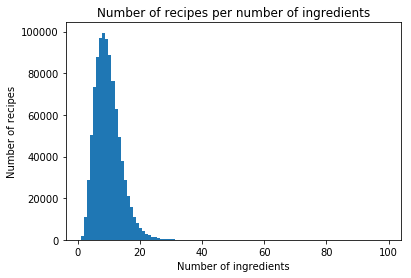

The median number of ingredients in a recipe is 9
The maximum of ingredients in a recipe is 99


In [10]:
# Count of ingredients for each recipe
counts = list(map(lambda r: len(r),all_recipes))

# Sort the counts
counts = sorted(counts, reverse=True)

# Plot the distribution of counts
plt.hist(counts, bins=100)
plt.title('Number of recipes per number of ingredients')
plt.xlabel('Number of ingredients')
plt.ylabel('Number of recipes')
plt.show()

print_bold('The median number of ingredients in a recipe is '+str(counts[int(len(counts)/2)]))
print_bold('The maximum of ingredients in a recipe is '+str(counts[0]))

> We see that the median number of ingredients is 9, which is not surprising. The distribution seems to be a gaussian with mean 9 and standard deviation of approximately 5. The maximum number of ingredients, 99, can be explained by recipes giving 'sub-recipes' for their ingredients. 

#### 2.2 Number of unique ingredients

In [11]:
all_ingr = []
for r in all_recipes:
    for i in r:
        all_ingr.append(i)
        
df_recipe = pd.Series(all_ingr)

print_bold('There are ' + str(len(df_recipe.unique())) + ' distinct ingredients')

There are 38182 distinct ingredients


> This is a huge number of ingredients, even considering our number of recipes. It is likely that a lot of ingredients are in fact some noise that we failed to filter during the parsing. Also, it is likely that several ingredients refer to the same ingredient but are written in different ways (e.g. "white rice" and "long-grain white rice"). <br>
To confirm, we look at the distribution of the ingredients.

#### 2.3 Distribution of the ingredients

Below, we sort the ingredients by the number of times they appear in the recipes

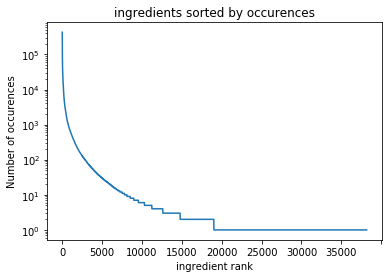

In [12]:
count_table = df_recipe.value_counts().to_frame().rename({0:'count'}, axis = 1)

# Log scale
ax = count_table['count'].plot(logy=True)
ax.set_xlabel('ingredient rank')
ax.set_ylabel('Number of occurences')
ax.set_title('ingredients sorted by occurences')
ax.set_xticklabels([0] + [5000*i for i in range(8)])
plt.show()

> Indeed, a lot of ingredients appear only a few times, actually not enough times for the embeddings to build accurate vector representations. Therefore, we decided to keep only the ingredients that appear in more than 15 recipes.

In [13]:
# The ingredients that appear more than 15 times 
without_junk = count_table[count_table['count'] > 15]
print_bold("We keep "+ "{:.2f}".format(100*((without_junk['count'].sum()) / count_table.sum())[0])+\
      "% of the data if we discard ingredients that appear in less than 15 recipes.")

print_bold("The number of distinct ingredients is now " + str(len(without_junk)) +\
           " (reduced by a factor " + "{:.3}".format(len(count_table) / len(without_junk)) +").")

We keep 99.13% of the data if we discard ingredients that appear in less than 15 recipes.
The number of distinct ingredients is now 6599 (reduced by a factor 5.79).


> We see that removing those ingredients does not damage the data so much, but allows us to reduce the number of ingredients in a very effective way.

## 3. USDA Mapping

#### 3.1 USDA database

> This section aims at giving an insight on the work that has been done on the USDA mapping. This work is necessary for the analysis conducted below as it is allows recipe healthiness evaluation. To get a more in-depth understanding, one can either consult the [USDA_parsing.ipnyb](USDA_parsing.ipynb) notebook or the [USDA_parsing.py](../python/USDA_parsing.py) source file.

To get the nutrients of each recipes, our approach consists in linking the different ingredients of a recipe to an entry of the USDA database. As every ingredient does not match exactly the description of a USDA entry, we designed a score function that indicates how well an ingredient matches a USDA entry.

In [14]:
# Relevant data for USDA
food_des_path = "./../data/usda/FOOD_DES.txt"
food_groups_path = "./../data/usda/FD_GROUP.txt"
nut_data_path = "./../data/usda/NUT_DATA.txt"
nut_def_path = "./../data/usda/NUTR_DEF.txt"

all_paths = [food_des_path, food_groups_path, nut_data_path, nut_def_path]

In [15]:
# Generate singularization engine
engine = inflect.engine()

# Columns we want to retrieve from the database files
columns = ["food_id", "food_group_id", "long_description", "common_names"]
use_cols = [0, 1, 2, 4]

# Get the info from file
food_des = pd.read_csv(food_des_path, sep="^", encoding="ISO-8859-1", names=columns, usecols=use_cols, header=None)

# Display original table format
print_bold("original table format : ")
print(food_des.head())


# Generate search_words
food_des['search_words'] = food_des.apply(lambda row : usda.concat_common_and_des(usda.format_long_des(row['common_names'], engine),
                                                                                  usda.format_long_des(row['long_description'], engine)),
                                                                                  axis=1)

# Drop common_names column
food_des = food_des.drop("common_names", axis=1)
            
print_bold("\n\nnew table format")
food_des.head()

original table format : 
   food_id  food_group_id            long_description common_names
0     1001            100              Butter, salted          NaN
1     1002            100  Butter, whipped, with salt          NaN
2     1003            100       Butter oil, anhydrous          NaN
3     1004            100                Cheese, blue          NaN
4     1005            100               Cheese, brick          NaN


new table format


,food_id,food_group_id,long_description,search_words
0,1001,100,"Butter, salted","[butter, salted]"
1,1002,100,"Butter, whipped, with salt","[butter, whipped, salt]"
2,1003,100,"Butter oil, anhydrous","[butter, oil, anhydrou]"
3,1004,100,"Cheese, blue","[cheese, blue]"
4,1005,100,"Cheese, brick","[cheese, brick]"


> The original table format is an extract of the USDA database. As it is not likely we have an ingredient matching the long description, we generate from the long description a set of search words. Those words are obtained by splitting the sentence by words, singularizing them and removing the words that give no information (e.g. "with"). This is what we can observe in the "new table format"

#### 3.2 Search function

>This is the score function we were referring to, it indicates how well an ingredient matches a USDA entry.
Here, the parameter 'categories' refers to the 'search_words' column of the usda entry, whereas 'ing_words' refers to the ingredient words. 

In [16]:
def search_score(categories, ing_words) :
    
    non_complexificators = set(["fresh", "raw", "skin", "peel", "whole"])
    
    # singularize search words
    ing_words = set([singularize_word(x) for x in ing_words])

    #prioritize matching query terms
    nb_matching = len(ing_words.intersection(set(categories)))

    #non_complexificators should not be penalized,ignore them AFTER computing number of matching words
    categories = [c for c in categories if (c not in non_complexificators)]


    #matching keywords one by one 
    matching = [len(set([x]).intersection(ing_words)) != 0 for x in categories]


    #first keywords are more important
    weights = np.linspace(2, 1, num=len(matching))
    weights = weights / sum(weights)

    #the query should have as many ingredients words as possible
    score = (10 * nb_matching) + sum([c[0] * c[1] for c in zip(matching, weights)])

    return score

>The design of the score function starts from three straightforward observations, namely :
- Lots of words in the long_description usually mean complex food item
- words in the long_description are ordered by descending relevance
- Some words (e.g ’raw’) do not make the food item more complex

>Note that the words that do not make the food-item more complex were chosen empirically.

#### 3.3 Examples

In [17]:
examples = ['raw chicken', 'chicken', 'fresh tomatoes', 'blue cheese', 'salt']

for example in examples :
    print_bold("Result of search for \'" + example + "\'\n")
    search_result = usda.search_ingredient(example, food_des, engine)[0]
    print(tabulate(search_result, headers='keys', tablefmt='psql'))
    print("\n\n")



Result of search for 'raw chicken'

+------+-----------+------------------------------+----------------+
|      |   food_id | search_words                 |   search_score |
|------+-----------+------------------------------+----------------|
| 1043 |      5332 | ['chicken', 'ground', 'raw'] |        20.6667 |
+------+-----------+------------------------------+----------------+



Result of search for 'chicken'

+------+-----------+------------------------+----------------+
|      |   food_id | search_words           |   search_score |
|------+-----------+------------------------+----------------|
| 7670 |     43128 | ['chicken', 'meatles'] |        10.6667 |
+------+-----------+------------------------+----------------+



Result of search for 'fresh tomatoes'

+------+-----------+-----------------------------+----------------+
|      |   food_id | search_words                |   search_score |
|------+-----------+-----------------------------+----------------|
| 2928 |     11695 | ['

> As we can see:
- The word 'raw does not penalize the matching, even the opposite as it allows to match a entry of the USDA more exactly.
- Tomatoes can be mapped on tomato

#### 3.4 Final mapping

> mapping_usda_id maps cleaned ingredients names to usda food ids

In [18]:
mapping_usda_id = json.load(open('../generated/ing_id_mapping.json'))  

mapping_usda_id['chicken']

43128

> The USDA_parsing notebook and script produce a ingredient mapping as a dictionary. The ingredient chicken is mapped on the USDA id 43128: [Chicken, meatless](https://ndb.nal.usda.gov/ndb/foods/show/43128?fgcd=&manu=&format=&count=&max=25&offset=&sort=default&order=asc&qlookup=43128&ds=&qt=&qp=&qa=&qn=&q=&ing=). Note that this mapping was found in the previous cell.

#### 3.5 Ingredients merging using representative

> The previous mapping already merged some ingredients together, more specifically the ones that were mapped to the same food ids. <br>For each food id, we create a string representation based on the names of the ingredients that were mapped on this id. The representation is composed of the words that occur in more than 50% of the names of the ingredients mapped on the id. Consequently, some ids end up with the same representation, this concludes the merging process.

This cell finds the ingredients that have been mapped to the same ids

In [19]:
mapped_ids = [mapping_usda_id[k] for k in mapping_usda_id]

#build dict to store collisions
collisions = {}

for m in tqdm(mapping_usda_id) :
    if mapping_usda_id[m] not in collisions.keys() :
        collisions[mapping_usda_id[m]] = [m]
        
    else :
        collisions[mapping_usda_id[m]].append(m)

100%|██████████| 2064/2064 [00:00<00:00, 906876.54it/s]


These are examples of such ingredients

In [20]:
[(c, collisions[c]) for c in collisions][:10]

[(2047, ['salt', 'kosher salt']),
 (1145, ['butter']),
 (19908, ['sugar', 'turbinado sugar', 'turbinado']),
 (11282, ['onion', 'onions']),
 (1123, ['egg']),
 (11981, ['pepper', 'peppers']),
 (14555, ['water']),
 (4053, ['olive oil', 'salad oil', 'olive salad']),
 (1212, ['milk']),
 (2030, ['black pepper'])]

> As we see, the mapping has been accurate enough

Now, we compute the representatives

In [21]:
proportion = 0.5

representative_keys = dict()

for i, c in tqdm(enumerate(collisions)) :
    
    all_items = " ".join(collisions[c]).split(" ")
    counter = collections.Counter()
    counter.update(all_items)

    #find common names
    common_names = [x[0] for x in counter.most_common() if x[1] > len(collisions[c])*proportion]

    #choose database description
    if len(common_names) == 0 :
        representative_keys[c] = collisions[c][0]

    elif len(common_names) == 1 :
        representative_keys[c] = common_names[0]

    else :
        #determine order

        #case 1, there exist an entry with only wanted words
        exact_match = [x.split(" ") for x in collisions[c] if (len(set(common_names).difference(set(x.split(" "))))== 0)]
        if len(exact_match) != 0 :
            representative_keys[c] = " ".join(exact_match[0])

        #case 2, no exact match
        else :

            all_words_collisions = [x.split(" ") for x in collisions[c] if set(common_names).issubset(set(x.split(" ")))]

            index_tuples = [ (word, index) for collision in all_words_collisions for index, word in enumerate(collision) if (word in common_names)]

            index_counts = np.array([0]*len(common_names))

            #average the relative indices
            for it in index_tuples :
                word_index = common_names.index(it[0])
                index_counts[word_index] += it[1]

            index_counts = index_counts

            common_names_ordered = " ".join([common_names[i] for i in np.argsort(index_counts)])
            representative_keys[c] = common_names_ordered



1559it [00:00, 101309.49it/s]


> What do the representatives look like ?

In [22]:
representative_keys

{2047: 'salt',
 1145: 'butter',
 19908: 'turbinado sugar',
 11282: 'onion',
 1123: 'egg',
 11981: 'pepper',
 14555: 'water',
 4053: 'olive oil salad',
 1212: 'milk',
 2030: 'black pepper',
 2050: 'vanilla',
 11695: 'tomato',
 20063: 'flour',
 19334: 'brown sugar',
 9152: 'lemon juice',
 28315: 'cinnamon',
 11297: 'parsley',
 18371: 'baking powder',
 4669: 'vegetable oil',
 11124: 'carrot',
 11215: 'garlic',
 18372: 'baking soda',
 1146: 'parmesan cheese',
 11216: 'ginger',
 2044: 'basil',
 11362: 'potato',
 16124: 'tamari soy sauce',
 2049: 'thyme',
 11165: 'cilantro',
 9156: 'lemon',
 7935: 'chicken breast',
 11292: 'green onion top',
 1179: 'sour cream',
 2027: 'oregano',
 19296: 'honey',
 2014: 'cumin',
 1270: 'cheddar',
 4572: 'nutmeg',
 1017: 'cream cheese',
 11143: 'celery',
 2020: 'garlic powder',
 6194: 'chicken soup',
 4532: 'oil',
 12071: 'almond',
 2028: 'paprika',
 43598: 'mayonnaise',
 1053: 'heavy cream',
 11993: 'mushroom',
 16104: 'bacon',
 20027: 'cornstarch',
 2004: '

> What are the collisions on representatives ?

In [23]:
collisions_repr = dict()

for repr_id in representative_keys :
    repr_name = representative_keys[repr_id]
    
    if repr_name in collisions_repr.keys() :
        collisions_repr[repr_name] += [repr_id]
    else :
        collisions_repr[repr_name] = [repr_id]
        

con = collections.Counter()
con.update([representative_keys[x] for x in representative_keys])

for c in con.most_common()[:10] :
    print("Representative term : ", c[0], " (", c[1], " times)")
    matching_keys = []
    for key in representative_keys :
        if representative_keys[key]== c[0] :
            print("\tusda food item : ", str(key))
            
            for ing in collisions[key] :
                print("\t\tingredient : ", ing)
            print("\n")
            
    print("\n")

Representative term :  butter  ( 3  times)
	usda food item :  1145
		ingredient :  butter


	usda food item :  12195
		ingredient :  almond butter
		ingredient :  nut butter


	usda food item :  4602
		ingredient :  stick butter
		ingredient :  sticks butter




Representative term :  water  ( 3  times)
	usda food item :  14555
		ingredient :  water


	usda food item :  14075
		ingredient :  sparkling water
		ingredient :  water 


	usda food item :  14155
		ingredient :  soda water
		ingredient :  tonic water




Representative term :  rice  ( 3  times)
	usda food item :  25071
		ingredient :  rice
		ingredient :  rice cracker


	usda food item :  20452
		ingredient :  white rice
		ingredient :  short-grain rice


	usda food item :  32002
		ingredient :  rice vermicelli
		ingredient :  rice pilaf mix




Representative term :  steak  ( 3  times)
	usda food item :  13000
		ingredient :  lean beef
		ingredient :  beef steak
		ingredient :  strip steak
		ingredient :  lean steak


	usda 

> We see that collisions on representative are accurate as well

## 4. Embeddings

>We got inspriration from the famous John Firth's quote, namely "you shall know a word by the company it keeps". This intuition seems valid when applied to ingredients, thus we decided to map the ingredients associations problem on the words associations one. We used a famous word embeddings library based on word2Vec to build our ingredients embeddings, considering each ingredient representation as a word, and each recipe as a sentence.

In [24]:
# Trained model that is used to compute the similirity between two ingredients
food_embeddings = models.Word2Vec.load('../generated/food_embeddings.bin')

In [25]:
food_embeddings.wv.most_similar('lettuce')

/home/luke/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('iceberg lettuce', 0.8824388384819031),
 ('romaine lettuce', 0.8092721700668335),
 ('green lettuce', 0.7680988311767578),
 ('salad green', 0.7646308541297913),
 ('green', 0.6246930360794067),
 ('salad dressing', 0.6189268231391907),
 ('cucumber', 0.5564990043640137),
 ('coleslaw', 0.5390306711196899),
 ('radish', 0.5378662943840027),
 ('avocado', 0.5250253677368164)]

>In this example, we see that the similarity is much higher. The first recommendations are indeed substitute of salads, but are not a very interesting swap to make in a recipe. Therefore, for our recommender algorithm, we chose not to consider substitute that have the same representative, to obtain more interesting swaps. After that, we see that the algorithm suggest swapping salad for salad dressing. Here, the reason is that the algorithm is biased by the omnipresence of dressing in a lot of salad recipes, and the algorithm sometimes considers ingredients that are often associated with the ingredient to swap

## 5. Recommender

> This section shows the result and a light implementation of the recommender described in our [report](). Its implementation can be consulted in more detailed in [recommender.py](../python/recommender.py). The word embedding model is trained and generated in the  [Food_Embeddings.ipnyb](/Food_Embeddings.ipnyb) notebook.

#### 5.1 Scripts

In [26]:
# Returns the score of an potential swap, taking into account the similarity and the health score
def health_similarity_score(similarity, health) :
    if health <= 7 :
        return similarity
    else :
        return (similarity**2 / health) 
        
# Find a swap for a given ingredient, similarity has to be superior than 0.45
def find_swaps(ing_id, threshold=0.45, nb=1) : 
    
    # Find the representative of the given ingredient
    try :        
        ing_ref = id_repr[str(ing_id)] 
        
    except KeyError:
        print("The ingredient with id", ing_id, "has never been seen before")  
        return None
    
    # Find the 50 most similar ingredients
    closest_refs = food_embeddings.wv.most_similar(ing_ref, topn=50)
    
    to_consider = []
    
    closest_refs_and_contains = list(filter(lambda x : (ing_ref     in x[0]) and (x[1] >= threshold), closest_refs))
    closest_refs_not_contains = list(filter(lambda x : (ing_ref not in x[0]) and (x[1] >= threshold), closest_refs))
    
    if len(closest_refs_not_contains) == 0 :
        to_consider = closest_refs_and_contains
    else :
        to_consider = closest_refs_not_contains
        
    if len(to_consider) == 0 :
        return None
    
    else :
        entries = []
        fat, sat_fat, sugar, salt, energy = ch.compute_profile([(100.0, ing_id)], nutrients_mapping)
        base_score = ch.score(fat, sat_fat, sugar, salt, energy)['total']
        for ref in to_consider :
            
            best_id = -1
            best_score = np.inf
            
            for collided_id in repr_ids[ref[0]] :
                fat, sat_fat, sugar, salt, energy = ch.compute_profile([(100.0, collided_id)], nutrients_mapping)

                score = ch.score(fat, sat_fat, sugar, salt, energy)['total']

                if score < best_score :
                    best_id = collided_id
                    best_score = score
            
            
            if (score < base_score) :
                entries.append((ref[0], ref[1], score))
        if len(entries) == 0 :
            return None
        else:
            return sorted(entries, key=lambda x : health_similarity_score(x[1], x[2]), reverse=True)[:nb]
        

# Apply the find_swaps function ofn every ingredient and determine which swap is the most interesting
def find_swapping(recipe) :
    swappings = []
    
    # Map every ingredients of a recipe to their USDA id and convert their quantities into grams
    recipe_info = ch.map_one_recipe_usda(recipe, mapping_usda_id, convert_gr, unit_quantities)
    if recipe_info is None :
        print("No swapping found")
    # Compute the score before any swaps.
    fat, sat_fat, sugar, salt, energy = ch.compute_profile(recipe_info, nutrients_mapping)
    old_score = ch.score(fat, sat_fat, sugar, salt, energy)['total']
    best_score = -1
    best_h_score = 99999
    best_swap = (None, None) 
    
    # Apply the swaps and keep the best score
    for e, (quant, ingr) in enumerate(recipe_info) :
        swap = find_swaps(ingr)

        if swap is not None :
            swap = swap[0]
            recipe_copy = [i for i in recipe_info]
            recipe_copy[e] = (recipe_copy[e][0],mapping_usda_id[swap[0]])
            fat, sat_fat, sugar, salt, energy = ch.compute_profile(recipe_copy, nutrients_mapping)
            h_score = ch.score(fat, sat_fat, sugar, salt, energy)['total']
            score = health_similarity_score(swap[1], h_score)
            
            if score > best_score :
                best_h_score = h_score
                best_score = score
                best_swap = (recipe[e][2], swap[0])
                
    new_score = best_h_score
    print('your recipe is',"{:.2f}".format((1-new_score/old_score)*100),'% healthier if you replace',best_swap[0],'with',best_swap[1])
    return best_swap
    

> Our procedure compute for each ingredient of a recipe the best swap available. It takes into account the healthiness that would be gained through the changement and the similarity of the ingredients we want to swap.


#### 5.2 Recommender applied on specific recipes

> To show our results, we chose 2 recipes on which we are going to apply our recommender to see its efficiency.

In [27]:
baking_recipe = ['384.0 g flour',
            '256.0 g turbinado sugar',
           '2.1 g cinnamon',
           '2.1 g clove',
           '2.1 g nutmeg',
           '96.0 g butter',
           '256.0 g buttermilk',
           '4.2 g baking soda',
           '128.0 g raisin',
           '128.0 g pistachio nut']

marmiton_top1 = ['1 kg veal',
                 '1 tsp chicken broth',
                 '2 carrots',
                 '1 onion',
                 '1 cup mushroom',
                 '1 cup cream',
                 '1 lemon',
                 '1 egg yolk',
                 '1 cup flour',
                 '1/4 kg white wine',
                 '2.5 g kosher salt',
                 '2.5 g pepper']

baking_recipe = [one_m.extract_quantity_from_raw(ingr) for ingr in baking_recipe]
baking_recipe = [[i[0],i[1],i[2]] for i in baking_recipe]

marmiton_top1 = [one_m.extract_quantity_from_raw(ingr) for ingr in marmiton_top1]
marmiton_top1 = [[i[0],i[1],i[2]] for i in marmiton_top1]

> Baking recipes contain often a lot a fat (through ingredients like butter) and a lot of sugar. We test our recommender on a bakery recipe from our dataset too see if we can make it lighter.

In [28]:
rc.find_swapping(baking_recipe)

your recipe is 23.04 % healthier if you replace butter with margarine


('butter', 'margarine')

> Let's test our recommender on the meal that is ranked first on the Marmiton website: The blanquette of veal


In [29]:
rc.find_swapping(marmiton_top1)

your recipe is 92.10 % healthier if you replace veal with rabbit


('veal', 'rabbit')

> This results in an original recipe that we can perfectly imagine to be tasty. Indeed, it appears that other white meats are often used as replacement for the veal in a blanquette.

> About the health score: we see that the new recipe is abnormally healthier than it should be. It appear that this is due to false positive during the mapping of some ingredients resulting in ingredients that have different nutrients that they should have